In [2]:
from ABDB import database as db
import numpy as np
from rich.progress import track
import copy
import torch
from sklearn.model_selection import train_test_split
from einops import rearrange
import json
import pandas as pd
from retrain_ablooper import *

/Users/fabian/miniconda3/envs/auto-db-pipeline/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(
Database path /Volumes/LaCie/sabdab-sabpred/data/ABDB was not found.


SyntaxError: closing parenthesis ')' does not match opening parenthesis '{' on line 116 (training.py, line 118)

### 1. Data preparation
**1.1 Get data from SAbDab**

Extract CDR sequencs and coordinate of backbone atoms from antibodies in SAbDab. This steps takes approximately 2 hrs, thus the output is saved in .npy file. Download all FABs from SAbDab and extract data about CDR and anchor sequences and backbone coordinates. Data is saved in a .npy file.

The set used for testing the model is the Rosetta antibody dataset. The pdb ids of these are indicated in './train_data/dataset.csv' with 'RAB' in the set column. The test set is loaded seperately from the other structures.

In [7]:
# get pdb ids of test set
all_ids = pd.read_csv('./train_data/datasets.csv')
test_ids = all_ids[all_ids['Set'] == 'RAB']
test_ids = test_ids.PDB_ID.values

In [8]:
# use imgt numbering
db.set_numbering_scheme("imgt")
db.set_region_definition("imgt")

# list of all pdb ids in SAbDab
all_pdbs_in_sabdab = list(db.db_summary.keys())
train_val_set = set(all_pdbs_in_sabdab) - set(test_ids)
len(train_val_set), len(all_pdbs_in_sabdab), len(test_ids)

(5721, 5770, 49)

In [42]:
# load test set
CDR_seqs_test, CDR_BB_coords_test = get_sabdab_fabs(test_ids)

with open('train_data/CDR_BB_coords_test.npy', 'wb') as outfile:
    np.save(outfile, CDR_BB_coords_test)

with open('train_data/CDR_seqs_test.npy', 'wb') as outfile:
    np.save(outfile, CDR_seqs_test)

Load data from SAbDab ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━  87% 0:00:02

In [3]:
# load training and validation set
CDR_seqs, CDR_BB_coords = get_sabdab_fabs(train_val_set)

with open('train_data/CDR_BB_coords.npy', 'wb') as outfile:
    np.save(outfile, CDR_BB_coords)

with open('train_data/CDR_seqs.npy', 'wb') as outfile:
    np.save(outfile, CDR_seqs)

NameError: name 'get_sabdab_fabs' is not defined

In [2]:
with open('train_data/CDR_BB_coords.npy', 'rb') as infile:
    CDR_BB_coords = np.load(infile, allow_pickle=True)

with open('train_data/CDR_seqs.npy', 'rb') as infile:
    CDR_seqs = np.load(infile, allow_pickle=True)

with open('train_data/CDR_BB_coords_test.npy', 'rb') as infile:
    CDR_BB_coords_test = np.load(infile, allow_pickle=True)

with open('train_data/CDR_seqs_test.npy', 'rb') as infile:
    CDR_seqs_test = np.load(infile, allow_pickle=True)

**1.2 Format data to model inputs**

Data loaded from SAbDab is reformated to model inputs and the training outputs. 

Each backbone atom corresponds to one node in the graph. The atoms are encoded into a vector with 41 elements (one-hot encoding of amino acid residue, one-hot encoding of atom type, one-hot encoding of CDR loop, positional encoding within loop).

The input coordinates of each backbone atoms are processed as follows. Anchor residues keep their original position, the CDR residues are spaced equally on a straigt line between the two anchors.

The training output coordinates correspond to the backbone coordinates from the crystal structure formated identically to the input coordinates.

In [3]:
# torch settings
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float)

In [4]:
geomins, node_encodings = prepare_model_inputs(CDR_seqs, CDR_BB_coords)
geomouts = prepare_model_output(CDR_BB_coords)

geomins_test, node_encodings_test = prepare_model_inputs(CDR_seqs_test, CDR_BB_coords_test)
geomouts_test = prepare_model_output(CDR_BB_coords_test)

Preparing model inputs ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Output()

CDR loops retrieve from SAbDab differ in numbers of residues. This leads to the node feature and coordinate tensors being of different sizes. When the model is trained in batches it cannot handle different formats of input tensors. 

To avoid this issues a mask is created. The mask is a vector of length 504 (which is the number of atoms in the longest Fab) and contains n_atoms * 1s and is filed up with 0s to 504. The coordinates and input node features are also padded to a size of 504 with 0s.

Format the data extracted in the previous step into the input tensors.

1. node_encodings: matrix of size 504 * 41, encoding node features
2. geomins: matrix of size 504 * 3, encoding the input coordinates of the CDR backbone residues (all residues equally spaced on a straight line between anchors)
3. geomouts: matrix of size 504 * 3, encoding the original coordinates of the CDR backbone residues

504 = number of atoms in longest FAB

Creates mask for each fab

In [5]:
masks = create_mask(node_encodings)
masks_test = create_mask(node_encodings_test)

Pads the node features and geoms to a length of 504

In [6]:
# pad all data
node_encodings = pad_list_of_tensors(node_encodings)
geomins = pad_list_of_tensors(geomins)
geomouts = pad_list_of_tensors(geomouts)
node_encodings_test = pad_list_of_tensors(node_encodings_test)
geomins_test = pad_list_of_tensors(geomins_test)
geomouts_test = pad_list_of_tensors(geomouts_test)


Concatenate the all data into a single array, where each element corresponds to a fab. Within an element the data is saved in a dictionary with keys: 'encodings', 'geomins', 'geomouts' and 'mask'

In [7]:
data = concatenate_data(node_encodings, geomins, geomouts, masks)
test = concatenate_data(node_encodings_test, geomins_test, geomouts_test, masks_test)
len(data), len(test)

(8071, 46)

**1.3 Prepare data for training**

In [8]:
# split in train and validation sets
train, validation = train_test_split(data, test_size=100, random_state=42)

len(train), len(validation), len(test)

(7971, 100, 46)

In [9]:
batch_size = 1
train_dataloader = torch.utils.data.DataLoader(train, 
                                               batch_size=batch_size,   # Batch size
                                               num_workers=1,           # Number of cpu's allocated to load the data (recommended is 4/GPU)
                                               shuffle=True,            # Whether to randomly shuffle data
                                               pin_memory=True,         # Enables faster data transfer to CUDA-enabled GPUs (page-locked memory)
                                               )

val_dataloader = torch.utils.data.DataLoader(validation, 
                                             batch_size=batch_size,
                                             num_workers=1,
                                             shuffle=True,
                                             pin_memory=True,
                                             )

test_dataloader = torch.utils.data.DataLoader(test, 
                                              batch_size=batch_size,
                                              num_workers=1,
                                              shuffle=True,
                                              pin_memory=True,
                                              )

### 2 Train model
**2.1 Run training code**

In [10]:
# initialise model
model = MaskDecoyGen().to(device = device).float()

# set optimiser
optimiser = torch.optim.RAdam(model.parameters(), lr=1e-3, weight_decay=1e-3)

# Step to actually train the network
train_losses, val_losses = train_model(model, optimiser, train_dataloader, val_dataloader, n_epochs=5000, patience=150, decoys=1)

Train model ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

KeyboardInterrupt: 

**2.1 Analyse trainig**

Model trained on 16-04, 1 decoy, optimiser: RAdam, 268 epochs, batch size = 1.

Plot losses

In [11]:
import matplotlib.pyplot as plt

In [12]:
def get_loss(loss_text, **kwargs):
    if kwargs['loss'] == 'train':
        which = 0
    elif kwargs['loss'] == 'val':
        which = 1
    
    losses = []
    loss_text = loss_text[1:] # remove header
    for i in range(len(loss_text)):
        losses.append(float(loss_text[i].strip().split('|')[which]))
    
    return np.asarray(losses)

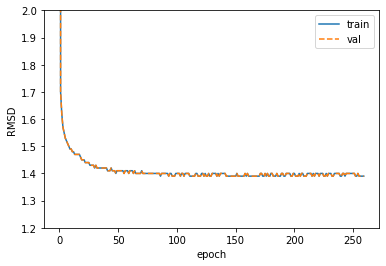

In [16]:
with open('losses_1604.out', 'r') as f:
    text = f.readlines()
loss_text = text[4:]

train_loss = get_loss(loss_text, loss='train')
val_loss = get_loss(loss_text, loss='val')

plt.plot(train_loss, label='train')
plt.plot(val_loss, '--', label='val')
plt.ylim((1.2,2))
plt.legend()
plt.ylabel('RMSD')
plt.xlabel('epoch')
plt.savefig('figures/train_val_losses-1604.png')

Get rmsd for each CDR on val set with best weights

In [17]:
# initialise model
model = MaskDecoyGen().to(device = device).float()
model.load_state_dict(torch.load("best_model", map_location=torch.device(device)))

<All keys matched successfully>

In [18]:
def cdr_rmsd_val_set(decoys, val_dataloader):
    '''
    Calculates the mean rmsd per cdr for a validation set
    '''
    CDRs = ['H1', 'H2', 'H3', 'L1', 'L2', 'L3']
    cdr_rmsds = torch.zeros(decoys, 100, len(CDRs))
    
    with torch.no_grad():
        model.eval() 

        for i, data in enumerate(val_dataloader):
            node_features = data['encodings']
            coordinates = data['geomins']
            out_coordinates = data['geomouts']
            mask = data['mask']

            pred = model(node_features, coordinates, mask)

            cdr_rmsds[:,i,:] = rmsd_per_cdr(pred, node_features, out_coordinates, CDRs, decoys)

        return cdr_rmsds.mean(1)


In [19]:
cdr_rmsd = cdr_rmsd_val_set(1, val_dataloader)

In [20]:
print('H1, H2, H3, L1, L2, L3')
cdr_rmsd

H1, H2, H3, L1, L2, L3


tensor([[1.2416, 1.2083, 3.2649, 1.2498, 0.6153, 1.3835]])

### 3. Use Pytorch lighting for training

In [27]:
import pytorch_lightning
from pytorch_lightning.loggers.neptune import NeptuneLogger

In [29]:
ourlogger = NeptuneLogger(api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMGI0ZTUzYy0zMTBkLTRjMWMtODhjNS0wNTJmNjA1MzhmOGMifQ==",
              project="fspoendlin/ABlooper",
              name="Fabian",
              log_model_checkpoints=False,
              )

trainer = pytorch_lightning.Trainer(
    accelerator="auto",  # 'cpu' or 'gpu'
    max_epochs=5000,
    check_val_every_n_epoch=1,
    accumulate_grad_batches=None,
    gradient_clip_val=1.0,
    logger=ourlogger,
    ) 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [30]:
model = pl_EGNNModel()
trainer.fit(model, train_dataloader, val_dataloader)


  | Name      | Type         | Params
-------------------------------------------
0 | egnnmodel | MaskDecoyGen | 662 K 
-------------------------------------------
662 K     Trainable params
0         Non-trainable params
662 K     Total params
2.649     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/fabian/miniconda3/envs/auto-db-pipeline/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/fabian/miniconda3/envs/auto-db-pipeline/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]